In [116]:
import numpy as np
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import time
import torch.optim as optim
#from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from collections import Counter
from scipy import interpolate

In [117]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

In [118]:
y_test = y_test - 769
y_train_valid = y_train_valid - 769
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [119]:
# 把最后一个axis变两倍， 500 -> 1000
def double_ax2(a):
    result = np.zeros((a.shape[0],a.shape[1],a.shape[2] * 2))
    b = np.reshape(a[:,:,-1],(a.shape[0],a.shape[1],1))
    aMod = np.concatenate((a,b),axis = 2)
    for i in range(a.shape[2]):
        ave = (aMod[:,:,i] + aMod[:,:,i+1]) / 2
        result[:,:,2 * i] = aMod[:,:,i]
        result[:,:,2*i + 1] = ave
    return result

In [120]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,X,Y):
        self.X = torch.FloatTensor(X)
        self.Y = torch.LongTensor(Y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index],self.Y[index]

In [121]:
#无downsample预处理过程
# For subject 1
X_train_valid_1 = X_train_valid[np.where(person_train_valid==0)[0]]
y_train_valid_1 = y_train_valid[np.where(person_train_valid==0)[0]]
X_test_1 = X_test[np.where(person_test==0)[0]]
y_test_1 = y_test[np.where(person_test==0)[0]]

from sklearn.model_selection import train_test_split
X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(X_train_valid_1, y_train_valid_1,
                                                              test_size=0.2,shuffle=True,stratify=y_train_valid_1)
#--------------------------------------------------------------------------------------------------------

train_set_1 = Dataset(X_train_1,y_train_1)
val_set_1 = Dataset(X_valid_1,y_valid_1)
test_set_1 = Dataset(X_test_1, y_test_1)
train_loader_1 = torch.utils.data.DataLoader(train_set_1,batch_size=32,shuffle=True)
val_loader_1 = torch.utils.data.DataLoader(val_set_1,batch_size=8,shuffle=True)
test_loader_1 = torch.utils.data.DataLoader(test_set_1,batch_size=10,shuffle=False)

In [122]:
'''
# upsample 预处理后

X_train_valid_1 = X_train_valid[np.where(person_train_valid==0)[0]]
y_train_valid_1 = y_train_valid[np.where(person_train_valid==0)[0]]


X_test_1 = X_test[np.where(person_test==0)[0]]
y_test_1 = y_test[np.where(person_test==0)[0]]

from sklearn.model_selection import train_test_split
X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(X_train_valid_1, y_train_valid_1,
                                                              test_size=0.2,shuffle=True,stratify=y_train_valid_1)


print(X_train_1.shape)


num_time = X_train_1.shape[2]
sample_1 = list(np.arange(0,num_time,2))
sample_2 = list(np.arange(1,num_time,2))

X_tr_1 = X_train_1[:,:,sample_1]
X_tr_2 = X_train_1[:,:,sample_2]
#X_test_s1 = X_test[:,:,sample_1]
#X_test_s2 = X_test[:,:,sample_2]
print('X_tr_1,  ',X_tr_1.shape)

#X_train_s = X_tr_1   # 这个只用了两组中的一组
X_train_s = np.concatenate((X_tr_1,X_tr_2), axis=0)  # 这个是两组都加进去， N 变成 N*3
#y_train_s = y_train_1  # 这个只用了两组中的一组
y_train_s = np.concatenate((y_train_1,y_train_1), axis=0) # 这个是两组都加进去， N 变成 N*3
print('X_train_s  ',X_train_s.shape)
X_train_s_x2 = double_ax2(X_train_s)
print(X_train_s_x2.shape)
X_train_s = X_train_s_x2
#X_train_s = np.concatenate((X_train_1,X_train_s_x2), axis=0)
print(X_train_s.shape)

y_train_s = y_train_s
#y_train_s = np.concatenate((y_train_1,y_train_s), axis=0)
print(y_train_s.shape)

#person_train_valid_s = np.concatenate((person_train_valid,person_train_valid,person_train_valid), axis=0)
#person_test_s = person_test
#X_test_s = np.concatenate((X_test_s1,X_test_s2), axis=0)
X_test_s = X_test_1
#X_test_s1
#y_test_s = np.concatenate((y_test,y_test), axis=0)
y_test_s = y_test_1
#y_test
#person_test_s = np.concatenate((person_test,person_test), axis=0)

print(X_train_s.shape)
print(y_train_s.shape)
print(X_test_s.shape)
#print(person_train_s.shape)
#print(person_test.shape)

train_set_1 = Dataset(X_train_s,y_train_s)
val_set_1 = Dataset(X_valid_1,y_valid_1)
test_set_1 = Dataset(X_test_1, y_test_1)
train_loader_1 = torch.utils.data.DataLoader(train_set_1,batch_size=32,shuffle=True)
val_loader_1 = torch.utils.data.DataLoader(val_set_1,batch_size=8,shuffle=True)
test_loader_1 = torch.utils.data.DataLoader(test_set_1,batch_size=10,shuffle=True)
'''

"\n# upsample 预处理后\n\nX_train_valid_1 = X_train_valid[np.where(person_train_valid==0)[0]]\ny_train_valid_1 = y_train_valid[np.where(person_train_valid==0)[0]]\n\n\nX_test_1 = X_test[np.where(person_test==0)[0]]\ny_test_1 = y_test[np.where(person_test==0)[0]]\n\nfrom sklearn.model_selection import train_test_split\nX_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(X_train_valid_1, y_train_valid_1,\n                                                              test_size=0.2,shuffle=True,stratify=y_train_valid_1)\n\n\nprint(X_train_1.shape)\n\n\nnum_time = X_train_1.shape[2]\nsample_1 = list(np.arange(0,num_time,2))\nsample_2 = list(np.arange(1,num_time,2))\n\nX_tr_1 = X_train_1[:,:,sample_1]\nX_tr_2 = X_train_1[:,:,sample_2]\n#X_test_s1 = X_test[:,:,sample_1]\n#X_test_s2 = X_test[:,:,sample_2]\nprint('X_tr_1,  ',X_tr_1.shape)\n\n#X_train_s = X_tr_1   # 这个只用了两组中的一组\nX_train_s = np.concatenate((X_tr_1,X_tr_2), axis=0)  # 这个是两组都加进去， N 变成 N*3\n#y_train_s = y_train_1  # 这个只用了两组中的一

In [123]:
class Conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(Conv, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.conv(x)
    
class ConvTranspose(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(ConvTranspose, self).__init__()
        
        self.conv = nn.Sequential(
            nn.ConvTranspose1d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.conv(x)

    
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        base = 22
        
        self.encoder = nn.Sequential(
            Conv(22, base, 3, stride=2, padding=1),
            Conv(base, 2*base, 3, padding=1),
            #Conv(2*base, 2*base, 3, stride=2, padding=1),
            #Conv(2*base, 2*base, 3, padding=1),
            Conv(2*base, 2*base, 3, stride=2, padding=1),
            Conv(2*base, 4*base, 3, padding=1),
            Conv(4*base, 4*base, 3, stride=2, padding=1),
            Conv(4*base, 4*base, 3, padding=1),
            Conv(4*base, 4*base, 3, stride=2, padding=1),
            nn.Conv1d(4*base, 64*base, 8),
            nn.LeakyReLU()
        )
        self.encoder_mu = nn.Conv1d(64*base, 32*base,1)
        self.encoder_logvar = nn.Conv1d(64*base, 32*base,1)
        
        self.decoder = nn.Sequential(
            nn.Conv1d(32*base, 64*base, 1),
            ConvTranspose(64*base, 4*base, 8),
            Conv(4*base, 4*base, 3, padding=1),
            ConvTranspose(4*base, 4*base, 3, stride=2, padding=1),
            Conv(4*base, 4*base, 3, padding=1),
            ConvTranspose(4*base, 4*base, 4, stride=2, padding=1),
            Conv(4*base, 2*base, 3, padding=1),
            ConvTranspose(2*base, 2*base, 3, stride=2, padding=0),
            #Conv(2*base, 2*base, 3, padding=1),
            #ConvTranspose(2*base, 2*base, 3, stride=2, padding=1),
            Conv(2*base, base, 3, padding=1),
            ConvTranspose(base, base, 3, stride=2, padding=0),
            nn.Conv1d(base, 22, 3, padding=1),
            nn.Tanh()
        )
        
    def encode(self, x):
        x = self.encoder(x)
        return self.encoder_mu(x), self.encoder_logvar(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [124]:
#目前这个最好
#只有FC有dropout
# [conv-relu]*2 -> 2*2 max-pooling -> [conv-relu]*3 -> 2*2 max_pooling -> (affine-relu)*2 -> affine -> softmax
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()  # initial the model
        self.vae = VAE()
        self.conv1 = nn.Conv1d(22,40,kernel_size = 2,stride = 2) 
        self.bn1 = nn.BatchNorm1d(40)
        self.conv2 = nn.Conv1d(40,60,kernel_size = 3,stride = 1) 
        self.bn2 = nn.BatchNorm1d(60) 
        self.pool1 = nn.MaxPool1d(2,2) 
        
        self.conv3 = nn.Conv1d(60,80,kernel_size = 3, stride = 1) 
        self.bn3 = nn.BatchNorm1d(80)
        self.conv4 = nn.Conv1d(80,100,kernel_size = 3, stride = 1) 
        self.bn4 = nn.BatchNorm1d(100)
        self.conv5 = nn.Conv1d(100,120,kernel_size = 3, stride = 2) #120*122
        self.bn5 = nn.BatchNorm1d(120)
        self.pool2 = nn.MaxPool1d(2,2) #120*61
        
        self.fc1 = nn.Linear(120*61, 300) # input dim , output dim
        self.bn6 = nn.BatchNorm1d(300)
        self.drop1 = nn.Dropout(0.8)
        self.fc2 = nn.Linear(300,4)  
        self.bn7 = nn.BatchNorm1d(40)
        self.drop2 = nn.Dropout(0.8)
        self.fc3 = nn.Linear(40,4)
 
    def forward(self,x):
        x = self.vae(x)[0]
        #print(x.shape)
        x = self.pool1(F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x)))))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(F.relu(self.bn5(self.conv5(x))))
        x = x.view(-1,120*61)
        
        x = self.drop1(F.relu(self.bn6(self.fc1(x))))
        #x = self.drop2(F.relu(self.bn7(self.fc2(x))))
        x = self.fc2(x)
        return x


In [125]:

model = Net()
print(model)
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(net.parameters(),lr = 0.01)
#optimizer = torch.optim.RMSprop(model.parameters(),lr = 0.001)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay = 5e-4)

Net(
  (vae): VAE(
    (encoder): Sequential(
      (0): Conv(
        (conv): Sequential(
          (0): Conv1d(22, 22, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
          (1): BatchNorm1d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01)
        )
      )
      (1): Conv(
        (conv): Sequential(
          (0): Conv1d(22, 44, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (1): BatchNorm1d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01)
        )
      )
      (2): Conv(
        (conv): Sequential(
          (0): Conv1d(44, 44, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
          (1): BatchNorm1d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01)
        )
      )
      (3): Conv(
        (conv): Sequential(
          (0): Conv1d(44, 88, kernel

In [126]:
val_acc_history = []
train_acc_history = []
test_acc_history = []
train_loss_history = []
val_loss_history = []
test_loss_history = []

In [127]:

t0 = time.time()
num_epochs = 125
for epoch in range(num_epochs):
    tstart = time.time()
    for i, data in enumerate(train_loader_1):
        inputs, labels = data
        #inputs = convnet(inputs)
        #inputs = torch.Tensor(inputs.detach().numpy().transpose(0,2,1)) #249*60
        model.train()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _,predicted = torch.max(outputs.data, 1)
        train_acc = (predicted == labels).sum().item() / len(labels)
        
    model.eval()
    train_correct, train_total = 0, 0
    train_loss = 0
    for train_data in train_loader_1:
        train_inputs, train_labels = train_data
        #train_inputs = convnet(train_inputs)
        #train_inputs = torch.Tensor(train_inputs.detach().numpy().transpose(0,2,1)) #249*60
        train_outputs = model(train_inputs)
        _, train_predicted = torch.max(train_outputs.data, 1)
        train_total += train_labels.size(0)
        train_correct += (train_predicted == train_labels).sum().item()
        train_loss += criterion(train_outputs, train_labels).item()
    train_acc = train_correct / train_total
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss)
        
    #pXtrain = model(Xtrain)
    #ptrain = torch.argmax(pXtrain, axis = 1)
    #train_acc = np.mean(ptrain.numpy() == ytrain.numpy())
    #train_accs.append(train_acc)
    #tloss = criterion(pXtrain, ytrain)
    #train_losses.append(tloss.item())
    model.eval()
    val_correct, val_total = 0, 0
    val_loss = 0
    for val_data in val_loader_1:
        val_inputs, val_labels = val_data
        #val_inputs = convnet(val_inputs)
        #val_inputs = torch.Tensor(val_inputs.detach().numpy().transpose(0,2,1)) #249*60
        val_outputs = model(val_inputs)
        _, val_predicted = torch.max(val_outputs.data, 1)
        val_total += val_labels.size(0)
        val_correct += (val_predicted == val_labels).sum().item()
        val_loss += criterion(val_outputs, val_labels).item()
    val_acc = val_correct / val_total
    val_acc_history.append(val_acc)
    val_loss_history.append(val_loss)
    
    model.eval()
    test_correct, test_total = 0, 0
    test_loss = 0
    for test_data in test_loader_1:
        test_inputs, test_labels = test_data
        #test_inputs = convnet(test_inputs)
        #test_inputs = torch.Tensor(test_inputs.detach().numpy().transpose(0,2,1)) #249*60
        test_outputs = model(test_inputs)
        _, test_predicted = torch.max(test_outputs.data, 1)
        test_total += test_labels.size(0)
        test_correct += (test_predicted == test_labels).sum().item()
        test_loss += criterion(test_outputs, test_labels).item()
    test_acc = test_correct / test_total
    test_acc_history.append(test_acc)
    test_loss_history.append(test_loss)
    
    #pXval = model(Xval)
    #pval = torch.argmax(pXval, axis = 1)
    #val_acc = np.mean(pval.numpy() == yval.numpy())
    #val_accs.append(val_acc)
    #vloss = criterion(pXval, yval)
    #val_losses.append(vloss.item())
    tend = time.time()
    print('epoch: {:<3d}    time: {:<3.2f}    train_loss: {:<3.3f}    train acc: {:<1.3f}    val_loss: {:<3.3f}    val acc: {:<1.3f}   test_loss: {:<3.3f}    test acc: {:<1.3f}'.format(epoch+1, 
            tend - tstart, train_loss, train_acc, val_loss, val_acc, test_loss, test_acc))
time_total = time.time() - t0
print('Total time: {:4.3f} seconds, average time per epoch: {:4.3f}'.format(time_total, time_total / num_epochs))
model.eval()
test_correct, test_total = 0, 0
for test_data in test_loader_1:
    test_inputs, test_labels = test_data
    #test_inputs = convnet(test_inputs)
    #test_inputs = torch.Tensor(test_inputs.detach().numpy().transpose(0,2,1)) #249*60
    test_outputs = model(test_inputs)
    _, test_predicted = torch.max(test_outputs.data, 1)
    test_total += test_labels.size(0)
    test_correct += (test_predicted == test_labels).sum().item()
test_acc = test_correct / test_total
print('Test accuracy is: ',test_acc)

epoch: 1      time: 9.22    train_loss: 8.332    train acc: 0.249    val_loss: 8.329    val acc: 0.250   test_loss: 6.938    test acc: 0.240
epoch: 2      time: 8.84    train_loss: 8.344    train acc: 0.249    val_loss: 8.344    val acc: 0.250   test_loss: 6.960    test acc: 0.240
epoch: 3      time: 8.84    train_loss: 8.404    train acc: 0.249    val_loss: 8.409    val acc: 0.250   test_loss: 7.043    test acc: 0.240
epoch: 4      time: 8.89    train_loss: 8.578    train acc: 0.249    val_loss: 8.576    val acc: 0.250   test_loss: 7.232    test acc: 0.240
epoch: 5      time: 8.93    train_loss: 8.744    train acc: 0.249    val_loss: 8.797    val acc: 0.250   test_loss: 7.405    test acc: 0.240
epoch: 6      time: 9.07    train_loss: 8.692    train acc: 0.249    val_loss: 8.733    val acc: 0.250   test_loss: 7.327    test acc: 0.240
epoch: 7      time: 9.37    train_loss: 8.672    train acc: 0.169    val_loss: 8.524    val acc: 0.271   test_loss: 7.364    test acc: 0.280
epoch: 8     

epoch: 60     time: 8.84    train_loss: 0.106    train acc: 1.000    val_loss: 9.161    val acc: 0.500   test_loss: 8.440    test acc: 0.500
epoch: 61     time: 8.91    train_loss: 0.112    train acc: 1.000    val_loss: 8.665    val acc: 0.521   test_loss: 8.282    test acc: 0.500
epoch: 62     time: 8.88    train_loss: 0.089    train acc: 1.000    val_loss: 10.706    val acc: 0.417   test_loss: 8.988    test acc: 0.560
epoch: 63     time: 8.89    train_loss: 0.087    train acc: 1.000    val_loss: 9.113    val acc: 0.542   test_loss: 8.301    test acc: 0.540
epoch: 64     time: 8.88    train_loss: 0.095    train acc: 1.000    val_loss: 9.617    val acc: 0.438   test_loss: 7.625    test acc: 0.620
epoch: 65     time: 8.90    train_loss: 0.139    train acc: 1.000    val_loss: 9.152    val acc: 0.438   test_loss: 8.166    test acc: 0.540
epoch: 66     time: 8.90    train_loss: 0.086    train acc: 1.000    val_loss: 9.505    val acc: 0.500   test_loss: 8.561    test acc: 0.520
epoch: 67   

epoch: 118    time: 9.07    train_loss: 0.011    train acc: 1.000    val_loss: 11.307    val acc: 0.479   test_loss: 9.719    test acc: 0.480
epoch: 119    time: 8.99    train_loss: 0.013    train acc: 1.000    val_loss: 10.575    val acc: 0.458   test_loss: 9.827    test acc: 0.480
epoch: 120    time: 9.01    train_loss: 0.009    train acc: 1.000    val_loss: 10.077    val acc: 0.542   test_loss: 9.004    test acc: 0.500
epoch: 121    time: 8.87    train_loss: 0.010    train acc: 1.000    val_loss: 10.751    val acc: 0.521   test_loss: 8.907    test acc: 0.560
epoch: 122    time: 8.95    train_loss: 0.009    train acc: 1.000    val_loss: 10.258    val acc: 0.479   test_loss: 8.454    test acc: 0.580
epoch: 123    time: 8.93    train_loss: 0.009    train acc: 1.000    val_loss: 10.623    val acc: 0.458   test_loss: 8.964    test acc: 0.480
epoch: 124    time: 8.90    train_loss: 0.010    train acc: 1.000    val_loss: 10.561    val acc: 0.458   test_loss: 8.732    test acc: 0.520
epoch:

Test accuracy is:  0.52


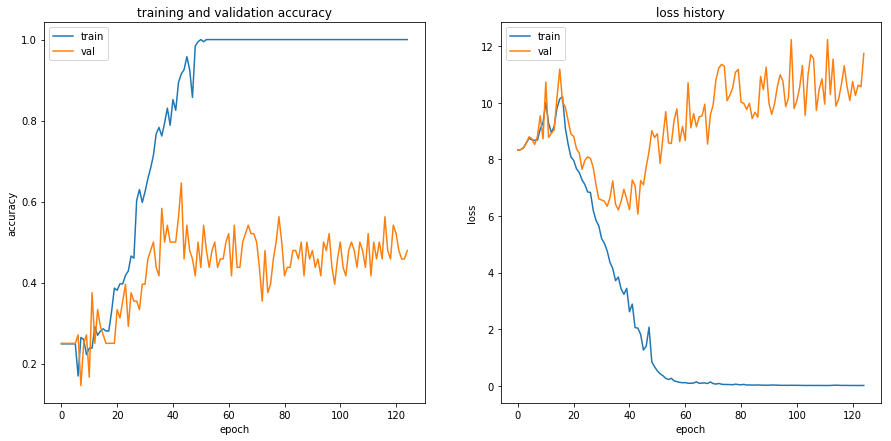

In [128]:
print('Test accuracy is: ',test_acc)
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.title('training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'])


plt.subplot(1, 2, 2)
plt.plot(train_loss_history)
plt.plot(val_loss_history)
plt.title('loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [50]:
net_1 = Net()
net_2 = Net()
net_3 = Net()
net_4 = Net()
net_5 = Net()
net_6 = Net()
net_7 = Net()
list_net = [net_1, net_2, net_3, net_4, net_5, net_6, net_7]
list_best_net = [Net(), Net(), Net(), Net(), Net(), Net(), Net()]
for n,net in enumerate(list_net):
    #val_acc_history = []
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.RMSprop(net.parameters(),lr = 0.001)
    print('--------------------------------------------------')
    print('Training Net {}'.format(n+1))
    for epoch in range(26):
        for i , data in enumerate(train_loader_1, 0):
            inputs, labels = data
            
            net.train()
            
            optimizer.zero_grad()
    
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            if i % 2 == 1:
                net.eval()
                val_correct, val_total = 0, 0 
                for val_data in val_loader_1:
                    val_images, val_labels = val_data
                    val_outputs = net(val_images)
                    _, val_predicted = torch.max(val_outputs.data, 1)
                    val_total += val_labels.size(0)
                    val_correct += (val_predicted == val_labels).sum().item()
                val_acc = val_correct / val_total
                print('Epoch {} | Iter{} | Loss{:.4f} | val acc {:.4f}'.format(
                    epoch, i , loss, val_acc))
                #writer.add_scalar('Train/Loss',loss,epoch*len(trainloader) + i)
                #writer.add_scalar('Train/ACC',train_acc,epoch*len(trainloader) + i)
                #writer.add_scalar('VAL/ACC',val_acc,epoch*len(trainloader) + i)
        #val_correct, val_total = 0, 0
        #for val_data in val_loader_1:
        #    val_images, val_labels = val_data
        #    val_outputs = net(val_images)
        #    _, val_predicted = torch.max(val_outputs.data, 1)
        #    val_total += val_labels.size(0)
        #    val_correct += (val_predicted == val_labels).sum().item()
        #val_acc = val_correct / val_total
        #val_acc_history.append(val_acc)
        #if val_acc == max(val_acc_history):
        #    list_best_net[n] = Net()
        #    list_best_net[n].load_state_dict(net.state_dict())
test_correct, test_total = 0, 0
for test_data in test_loader_1:
    test_images, test_labels = test_data
    test_predicted_list = []
    for net in list_net:
    #for net_best in list_best_net:
        test_outputs = net(test_images)
        #test_outputs = net_best(test_images)
        _, test_predicted = torch.max(test_outputs.data, 1)
        test_predicted_list.append(test_predicted.numpy())
    test_predicted_list = np.array(test_predicted_list)
    test_predicted_result = []
    for vote in range(np.shape(test_predicted_list)[1]):
        test_predicted_result.append(Counter(test_predicted_list[:,vote]).most_common(1)[0][0])
    test_predicted = torch.Tensor(test_predicted_result)
    test_total += test_labels.size(0)
    test_correct += (test_predicted == test_labels).sum().item()
test_acc = test_correct / test_total
print('Test accuracy is: ',test_acc)

--------------------------------------------------
Training Net 1
Epoch 0 | Iter1 | Loss1.6369 | val acc 0.3750
Epoch 0 | Iter3 | Loss1.7491 | val acc 0.3750
Epoch 0 | Iter5 | Loss1.8225 | val acc 0.3750
Epoch 0 | Iter7 | Loss1.8248 | val acc 0.3125
Epoch 0 | Iter9 | Loss1.5488 | val acc 0.2917
Epoch 0 | Iter11 | Loss1.5226 | val acc 0.2708
Epoch 0 | Iter13 | Loss1.4853 | val acc 0.3333
Epoch 0 | Iter15 | Loss1.5834 | val acc 0.3542
Epoch 0 | Iter17 | Loss1.4572 | val acc 0.3958
Epoch 1 | Iter1 | Loss1.5596 | val acc 0.3333
Epoch 1 | Iter3 | Loss1.1818 | val acc 0.3125
Epoch 1 | Iter5 | Loss1.4253 | val acc 0.3542
Epoch 1 | Iter7 | Loss1.3930 | val acc 0.3125
Epoch 1 | Iter9 | Loss1.5970 | val acc 0.3333
Epoch 1 | Iter11 | Loss1.2510 | val acc 0.3958
Epoch 1 | Iter13 | Loss1.2624 | val acc 0.3542
Epoch 1 | Iter15 | Loss1.3322 | val acc 0.3750
Epoch 1 | Iter17 | Loss1.4076 | val acc 0.3542
Epoch 2 | Iter1 | Loss1.3967 | val acc 0.1875
Epoch 2 | Iter3 | Loss1.2543 | val acc 0.3125
Epoch 

Epoch 19 | Iter7 | Loss0.3091 | val acc 0.5417
Epoch 19 | Iter9 | Loss0.2635 | val acc 0.5417
Epoch 19 | Iter11 | Loss0.3395 | val acc 0.5208
Epoch 19 | Iter13 | Loss0.3545 | val acc 0.4583
Epoch 19 | Iter15 | Loss0.4491 | val acc 0.5208
Epoch 19 | Iter17 | Loss0.3643 | val acc 0.6250
Epoch 20 | Iter1 | Loss0.3242 | val acc 0.5625
Epoch 20 | Iter3 | Loss0.1405 | val acc 0.5833
Epoch 20 | Iter5 | Loss0.5106 | val acc 0.5833
Epoch 20 | Iter7 | Loss0.2365 | val acc 0.5417
Epoch 20 | Iter9 | Loss0.4577 | val acc 0.5833
Epoch 20 | Iter11 | Loss0.3698 | val acc 0.5000
Epoch 20 | Iter13 | Loss0.4515 | val acc 0.6250
Epoch 20 | Iter15 | Loss0.3155 | val acc 0.6250
Epoch 20 | Iter17 | Loss0.4360 | val acc 0.5833
Epoch 21 | Iter1 | Loss0.2841 | val acc 0.6042
Epoch 21 | Iter3 | Loss0.1654 | val acc 0.5417
Epoch 21 | Iter5 | Loss0.3551 | val acc 0.4375
Epoch 21 | Iter7 | Loss0.3774 | val acc 0.5625
Epoch 21 | Iter9 | Loss0.4002 | val acc 0.5833
Epoch 21 | Iter11 | Loss0.3028 | val acc 0.5417
Epoc

Epoch 12 | Iter13 | Loss0.5614 | val acc 0.6667
Epoch 12 | Iter15 | Loss0.4491 | val acc 0.6667
Epoch 12 | Iter17 | Loss0.4500 | val acc 0.6250
Epoch 13 | Iter1 | Loss0.5091 | val acc 0.6875
Epoch 13 | Iter3 | Loss0.4886 | val acc 0.6458
Epoch 13 | Iter5 | Loss0.3700 | val acc 0.6458
Epoch 13 | Iter7 | Loss0.4390 | val acc 0.6250
Epoch 13 | Iter9 | Loss0.5623 | val acc 0.6667
Epoch 13 | Iter11 | Loss0.4018 | val acc 0.6042
Epoch 13 | Iter13 | Loss0.4504 | val acc 0.6875
Epoch 13 | Iter15 | Loss0.4194 | val acc 0.6250
Epoch 13 | Iter17 | Loss0.3816 | val acc 0.6250
Epoch 14 | Iter1 | Loss0.4634 | val acc 0.6042
Epoch 14 | Iter3 | Loss0.6179 | val acc 0.6667
Epoch 14 | Iter5 | Loss0.3669 | val acc 0.7083
Epoch 14 | Iter7 | Loss0.4292 | val acc 0.6875
Epoch 14 | Iter9 | Loss0.6855 | val acc 0.5625
Epoch 14 | Iter11 | Loss0.4533 | val acc 0.6667
Epoch 14 | Iter13 | Loss0.4271 | val acc 0.6667
Epoch 14 | Iter15 | Loss0.4015 | val acc 0.6042
Epoch 14 | Iter17 | Loss0.4293 | val acc 0.6875
Ep

Epoch 5 | Iter17 | Loss0.9718 | val acc 0.5208
Epoch 6 | Iter1 | Loss0.8852 | val acc 0.5000
Epoch 6 | Iter3 | Loss0.8972 | val acc 0.5625
Epoch 6 | Iter5 | Loss0.7457 | val acc 0.5000
Epoch 6 | Iter7 | Loss0.9776 | val acc 0.6042
Epoch 6 | Iter9 | Loss0.7779 | val acc 0.5625
Epoch 6 | Iter11 | Loss0.7557 | val acc 0.5625
Epoch 6 | Iter13 | Loss0.8284 | val acc 0.6458
Epoch 6 | Iter15 | Loss0.8060 | val acc 0.5625
Epoch 6 | Iter17 | Loss0.7045 | val acc 0.6458
Epoch 7 | Iter1 | Loss0.8630 | val acc 0.5208
Epoch 7 | Iter3 | Loss0.8706 | val acc 0.5625
Epoch 7 | Iter5 | Loss0.7685 | val acc 0.5417
Epoch 7 | Iter7 | Loss0.8901 | val acc 0.6458
Epoch 7 | Iter9 | Loss0.7537 | val acc 0.6250
Epoch 7 | Iter11 | Loss0.7315 | val acc 0.6250
Epoch 7 | Iter13 | Loss0.8293 | val acc 0.5625
Epoch 7 | Iter15 | Loss0.7350 | val acc 0.6250
Epoch 7 | Iter17 | Loss0.8184 | val acc 0.5208
Epoch 8 | Iter1 | Loss0.6730 | val acc 0.6042
Epoch 8 | Iter3 | Loss0.7802 | val acc 0.5833
Epoch 8 | Iter5 | Loss0.6

Epoch 25 | Iter5 | Loss0.2435 | val acc 0.7083
Epoch 25 | Iter7 | Loss0.2404 | val acc 0.6667
Epoch 25 | Iter9 | Loss0.3568 | val acc 0.7083
Epoch 25 | Iter11 | Loss0.3816 | val acc 0.7083
Epoch 25 | Iter13 | Loss0.1300 | val acc 0.7083
Epoch 25 | Iter15 | Loss0.3541 | val acc 0.7083
Epoch 25 | Iter17 | Loss0.2139 | val acc 0.6875
--------------------------------------------------
Training Net 4
Epoch 0 | Iter1 | Loss1.5047 | val acc 0.3750
Epoch 0 | Iter3 | Loss1.4869 | val acc 0.3750
Epoch 0 | Iter5 | Loss1.5971 | val acc 0.4375
Epoch 0 | Iter7 | Loss1.7690 | val acc 0.3750
Epoch 0 | Iter9 | Loss1.5654 | val acc 0.4792
Epoch 0 | Iter11 | Loss1.3856 | val acc 0.4375
Epoch 0 | Iter13 | Loss1.3477 | val acc 0.3542
Epoch 0 | Iter15 | Loss1.5447 | val acc 0.4167
Epoch 0 | Iter17 | Loss1.3452 | val acc 0.3958
Epoch 1 | Iter1 | Loss1.3476 | val acc 0.3958
Epoch 1 | Iter3 | Loss1.2933 | val acc 0.5000
Epoch 1 | Iter5 | Loss1.3011 | val acc 0.4792
Epoch 1 | Iter7 | Loss1.3818 | val acc 0.4583

Epoch 18 | Iter11 | Loss0.2201 | val acc 0.5208
Epoch 18 | Iter13 | Loss0.4066 | val acc 0.5000
Epoch 18 | Iter15 | Loss0.3420 | val acc 0.5417
Epoch 18 | Iter17 | Loss0.3734 | val acc 0.5625
Epoch 19 | Iter1 | Loss0.4022 | val acc 0.6042
Epoch 19 | Iter3 | Loss0.4402 | val acc 0.5833
Epoch 19 | Iter5 | Loss0.3533 | val acc 0.6042
Epoch 19 | Iter7 | Loss0.5149 | val acc 0.5833
Epoch 19 | Iter9 | Loss0.2796 | val acc 0.5208
Epoch 19 | Iter11 | Loss0.2680 | val acc 0.5417
Epoch 19 | Iter13 | Loss0.2818 | val acc 0.5000
Epoch 19 | Iter15 | Loss0.2686 | val acc 0.5208
Epoch 19 | Iter17 | Loss0.3938 | val acc 0.5625
Epoch 20 | Iter1 | Loss0.3304 | val acc 0.5000
Epoch 20 | Iter3 | Loss0.3059 | val acc 0.5417
Epoch 20 | Iter5 | Loss0.2338 | val acc 0.5208
Epoch 20 | Iter7 | Loss0.4147 | val acc 0.5625
Epoch 20 | Iter9 | Loss0.2867 | val acc 0.6042
Epoch 20 | Iter11 | Loss0.2601 | val acc 0.5625
Epoch 20 | Iter13 | Loss0.5061 | val acc 0.6042
Epoch 20 | Iter15 | Loss0.2884 | val acc 0.5833
Ep

Epoch 11 | Iter17 | Loss0.7050 | val acc 0.3750
Epoch 12 | Iter1 | Loss0.5055 | val acc 0.4167
Epoch 12 | Iter3 | Loss0.5461 | val acc 0.4583
Epoch 12 | Iter5 | Loss0.4895 | val acc 0.4167
Epoch 12 | Iter7 | Loss0.6098 | val acc 0.4583
Epoch 12 | Iter9 | Loss0.3814 | val acc 0.3958
Epoch 12 | Iter11 | Loss0.6205 | val acc 0.4583
Epoch 12 | Iter13 | Loss0.6246 | val acc 0.4375
Epoch 12 | Iter15 | Loss0.4480 | val acc 0.4792
Epoch 12 | Iter17 | Loss0.6936 | val acc 0.4792
Epoch 13 | Iter1 | Loss0.6266 | val acc 0.4375
Epoch 13 | Iter3 | Loss0.4834 | val acc 0.4583
Epoch 13 | Iter5 | Loss0.5362 | val acc 0.5000
Epoch 13 | Iter7 | Loss0.7015 | val acc 0.5000
Epoch 13 | Iter9 | Loss0.4645 | val acc 0.4167
Epoch 13 | Iter11 | Loss0.5601 | val acc 0.3750
Epoch 13 | Iter13 | Loss0.4707 | val acc 0.4792
Epoch 13 | Iter15 | Loss0.4133 | val acc 0.4167
Epoch 13 | Iter17 | Loss0.5999 | val acc 0.4792
Epoch 14 | Iter1 | Loss0.4800 | val acc 0.5000
Epoch 14 | Iter3 | Loss0.4589 | val acc 0.5000
Epoc

Epoch 5 | Iter3 | Loss0.8583 | val acc 0.5833
Epoch 5 | Iter5 | Loss0.9842 | val acc 0.5208
Epoch 5 | Iter7 | Loss0.9937 | val acc 0.5208
Epoch 5 | Iter9 | Loss0.9218 | val acc 0.6042
Epoch 5 | Iter11 | Loss0.8256 | val acc 0.6250
Epoch 5 | Iter13 | Loss0.9984 | val acc 0.6042
Epoch 5 | Iter15 | Loss0.8224 | val acc 0.5625
Epoch 5 | Iter17 | Loss1.1018 | val acc 0.5000
Epoch 6 | Iter1 | Loss0.9911 | val acc 0.5625
Epoch 6 | Iter3 | Loss0.8184 | val acc 0.5625
Epoch 6 | Iter5 | Loss0.7684 | val acc 0.5625
Epoch 6 | Iter7 | Loss0.9246 | val acc 0.5417
Epoch 6 | Iter9 | Loss0.7255 | val acc 0.5000
Epoch 6 | Iter11 | Loss0.9119 | val acc 0.4792
Epoch 6 | Iter13 | Loss0.7612 | val acc 0.5833
Epoch 6 | Iter15 | Loss0.8456 | val acc 0.4792
Epoch 6 | Iter17 | Loss0.8911 | val acc 0.6042
Epoch 7 | Iter1 | Loss0.8506 | val acc 0.6250
Epoch 7 | Iter3 | Loss0.7708 | val acc 0.5417
Epoch 7 | Iter5 | Loss0.7328 | val acc 0.5208
Epoch 7 | Iter7 | Loss0.9244 | val acc 0.5417
Epoch 7 | Iter9 | Loss0.82

Epoch 24 | Iter9 | Loss0.1621 | val acc 0.7083
Epoch 24 | Iter11 | Loss0.3006 | val acc 0.6875
Epoch 24 | Iter13 | Loss0.3028 | val acc 0.6458
Epoch 24 | Iter15 | Loss0.3159 | val acc 0.7292
Epoch 24 | Iter17 | Loss0.1906 | val acc 0.7500
Epoch 25 | Iter1 | Loss0.1845 | val acc 0.7083
Epoch 25 | Iter3 | Loss0.4183 | val acc 0.7292
Epoch 25 | Iter5 | Loss0.2355 | val acc 0.6875
Epoch 25 | Iter7 | Loss0.3658 | val acc 0.7083
Epoch 25 | Iter9 | Loss0.2371 | val acc 0.6875
Epoch 25 | Iter11 | Loss0.3319 | val acc 0.7292
Epoch 25 | Iter13 | Loss0.2672 | val acc 0.7500
Epoch 25 | Iter15 | Loss0.2633 | val acc 0.7083
Epoch 25 | Iter17 | Loss0.2651 | val acc 0.7917
--------------------------------------------------
Training Net 7
Epoch 0 | Iter1 | Loss1.5614 | val acc 0.1667
Epoch 0 | Iter3 | Loss1.4592 | val acc 0.1667
Epoch 0 | Iter5 | Loss1.7603 | val acc 0.1667
Epoch 0 | Iter7 | Loss1.5689 | val acc 0.1250
Epoch 0 | Iter9 | Loss1.7458 | val acc 0.0833
Epoch 0 | Iter11 | Loss1.5826 | val ac

Epoch 17 | Iter15 | Loss0.3583 | val acc 0.4583
Epoch 17 | Iter17 | Loss0.3956 | val acc 0.5000
Epoch 18 | Iter1 | Loss0.4121 | val acc 0.5000
Epoch 18 | Iter3 | Loss0.4961 | val acc 0.6250
Epoch 18 | Iter5 | Loss0.4526 | val acc 0.5833
Epoch 18 | Iter7 | Loss0.3878 | val acc 0.6250
Epoch 18 | Iter9 | Loss0.4745 | val acc 0.4792
Epoch 18 | Iter11 | Loss0.3426 | val acc 0.5000
Epoch 18 | Iter13 | Loss0.3883 | val acc 0.6250
Epoch 18 | Iter15 | Loss0.2389 | val acc 0.6250
Epoch 18 | Iter17 | Loss0.3214 | val acc 0.6667
Epoch 19 | Iter1 | Loss0.3280 | val acc 0.3958
Epoch 19 | Iter3 | Loss0.5195 | val acc 0.5000
Epoch 19 | Iter5 | Loss0.4460 | val acc 0.5208
Epoch 19 | Iter7 | Loss0.3542 | val acc 0.6042
Epoch 19 | Iter9 | Loss0.4021 | val acc 0.6042
Epoch 19 | Iter11 | Loss0.4237 | val acc 0.5208
Epoch 19 | Iter13 | Loss0.4658 | val acc 0.4792
Epoch 19 | Iter15 | Loss0.3429 | val acc 0.3958
Epoch 19 | Iter17 | Loss0.4284 | val acc 0.5208
Epoch 20 | Iter1 | Loss0.3950 | val acc 0.5625
Epo